In [ ]:
# Rock-Paper-Scissors Classifier with InceptionV3
# Dataset: https://www.tensorflow.org/datasets/catalog/rock_paper_scissors

In [1]:
# @title Setup and Imports
!pip install -q tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to dataset
dataset_path = '/content/drive/MyDrive/project'
img_size = (224, 224)
batch_size = 32
seed = 42

In [4]:

# @title Load and Prepare Dataset
# Load Rock-Paper-Scissors dataset
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.7QO63N_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.7QO63N_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [5]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150))  # InceptionV3 default input size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

In [6]:
# Prepare datasets
batch_size = 32
train_ds = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

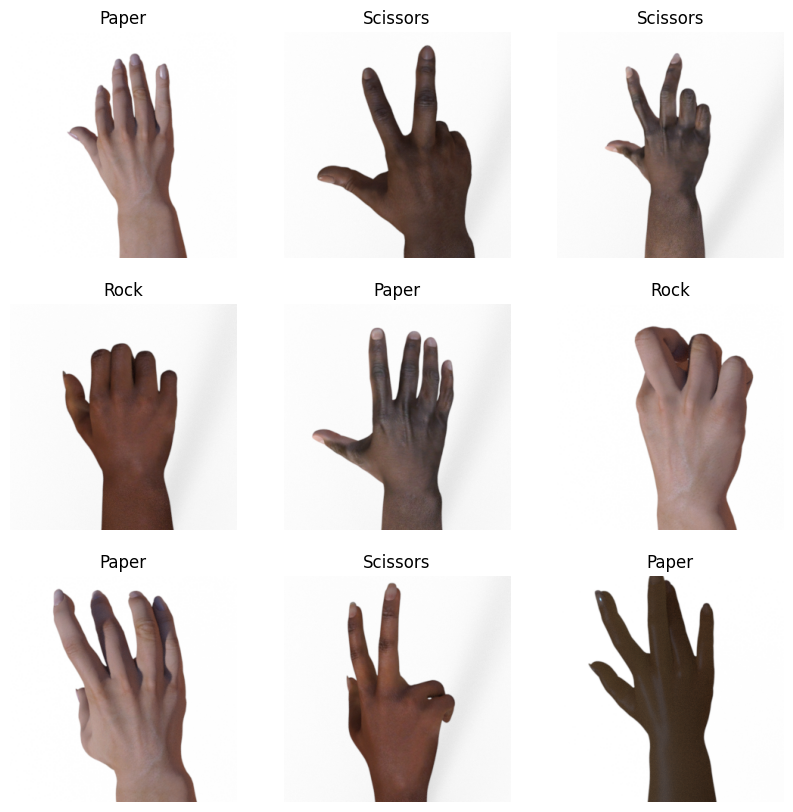

In [7]:
# Show sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(['Rock', 'Paper', 'Scissors'][label])
    plt.axis('off')
plt.show()

In [8]:
# @title Build InceptionV3 Model
# Load pre-trained InceptionV3 (without top layers)
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Freeze the base model
base_model.trainable = False

In [10]:
# Build custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])


In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,934,115 (83.67 MB)

 Trainable params: 131,331 (513.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [13]:
# @title Train the Model
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds
)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8182 - loss: 0.4744 - val_accuracy: 0.7285 - val_loss: 0.4852
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9977 - loss: 0.0154 - val_accuracy: 0.7473 - val_loss: 0.4735
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7876 - val_loss: 0.4038
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8065 - val_loss: 0.3719
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8172 - val_loss: 0.3693


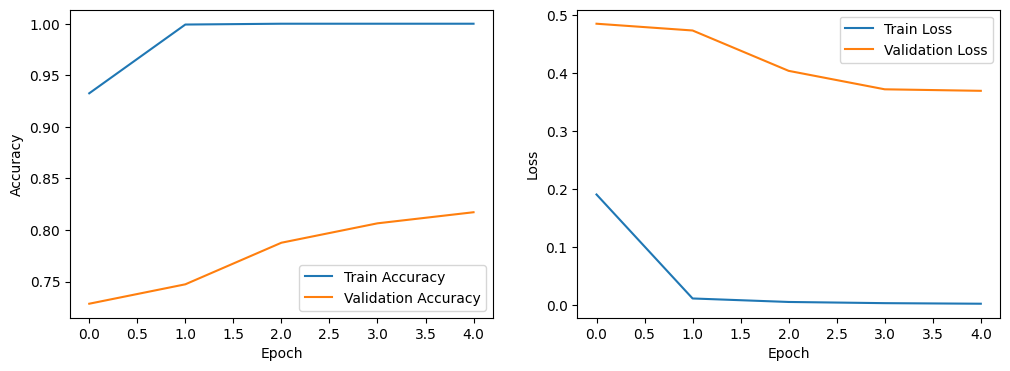

In [14]:
# @title Evaluate the Model
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - accuracy: 0.8059 - loss: 0.3859

Test Accuracy: 0.8172


In [16]:
# @title Make Predictions
# Get sample test images
sample_images, sample_labels = next(iter(test_ds))
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


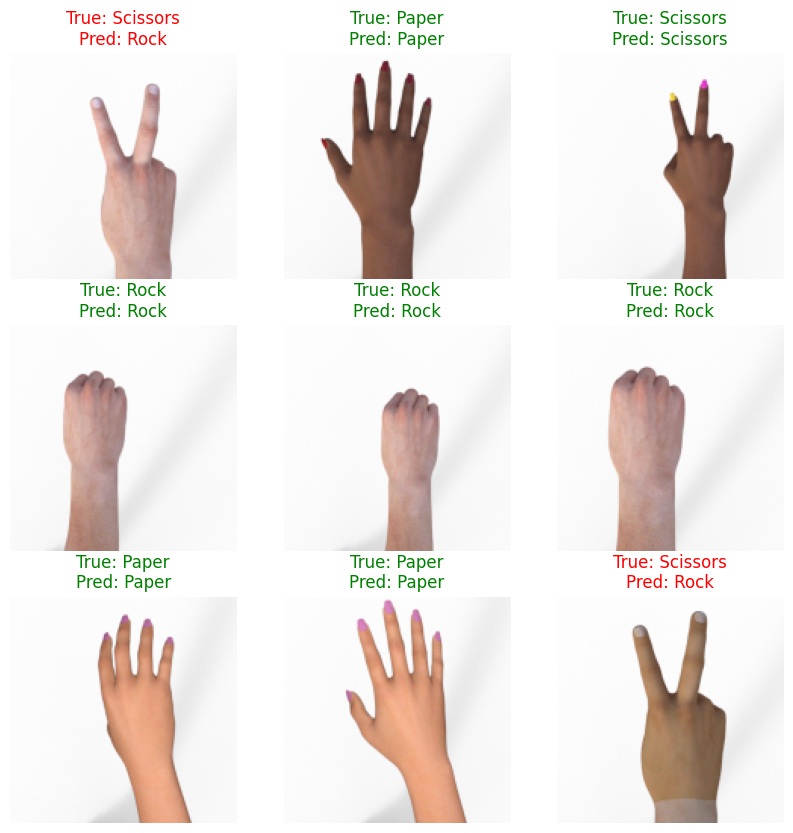

In [17]:
# Display predictions
class_names = ['Rock', 'Paper', 'Scissors']
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    color = 'green' if sample_labels[i] == predicted_labels[i] else 'red'
    plt.title(f"True: {class_names[sample_labels[i]]}\nPred: {class_names[predicted_labels[i]]}", color=color)
    plt.axis('off')
plt.show()

In [18]:
# @title Save Model in Keras Format
model.save('rps_inceptionv3.keras')  # Saves in modern Keras format